In [58]:
#This project aims to forecast the following stocks: Synchron 
#Load all the libraries 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
!pip install pmdarima
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [27]:
# loading and looking at synchron technologies data (you also want to look at tail because you want to make sure its the most up to date data you have)
sync = pd.read_csv("SNCR.csv")
print(sync.head())
print(sync.tail())

         Date  Open  High   Low  Close  Adj Close   Volume
0  2021-08-04  2.99  3.02  2.87   2.90       2.90   615000
1  2021-08-05  2.91  2.96  2.87   2.91       2.91   284100
2  2021-08-06  2.95  2.97  2.89   2.95       2.95   347700
3  2021-08-09  2.93  2.97  2.88   2.95       2.95   418100
4  2021-08-10  2.77  2.87  2.69   2.72       2.72  1625600
           Date  Open  High   Low  Close  Adj Close  Volume
248  2022-07-29  1.33  1.37  1.28   1.34       1.34   58800
249  2022-08-01  1.35  1.52  1.29   1.45       1.45  221100
250  2022-08-02  1.47  1.63  1.41   1.60       1.60  230300
251  2022-08-03  1.60  1.64  1.59   1.62       1.62   94500
252  2022-08-04  1.62  1.64  1.57   1.62       1.62   88022


In [70]:
# data cleansing 
sync['Close'].isnull().values.any()
# it returns false, we do not have any null data

#want to look at the statistical char. of the data 
print(sync.describe())

             Open        High         Low       Close   Adj Close  \
count  253.000000  253.000000  253.000000  253.000000  253.000000   
mean     1.988142    2.047826    1.930751    1.985692    1.985692   
std      0.551546    0.558712    0.539443    0.551117    0.551117   
min      1.120000    1.150000    1.060000    1.110000    1.110000   
25%      1.470000    1.540000    1.410000    1.460000    1.460000   
50%      2.060000    2.100000    1.990000    2.040000    2.040000   
75%      2.470000    2.530000    2.420000    2.480000    2.480000   
max      3.060000    3.090000    2.890000    3.040000    3.040000   

             Volume  differenced close  differenced close   
count  2.530000e+02         252.000000          252.000000  
mean   4.405305e+05          -0.005079           -0.005079  
std    4.114014e+05           0.080973            0.080973  
min    2.220000e+04          -0.290000           -0.290000  
25%    1.947000e+05          -0.050000           -0.050000  
50%    3.477

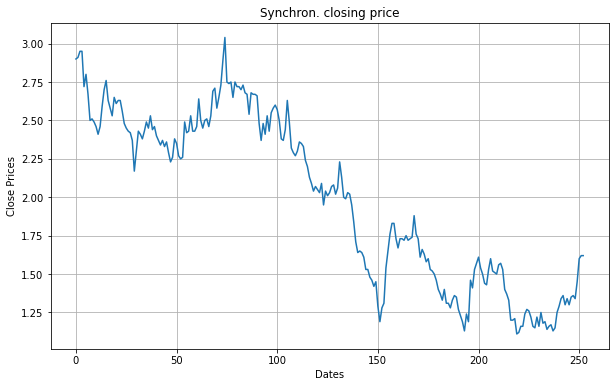

In [71]:
# data visualization 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(sync['Close'])
plt.title('Synchron. closing price')
plt.show()

#just based off visual insepction of the data, the Syncrhon closing prices does not seem stationary 


In [72]:
#check for stationarity 
# unit root test using DF test (the null: the series has a unit root of 1, If we fail to reject the null hypothesis, we can say that the series is non-stationary.)
adfuller(sync['Close']) 
# p value is 0.45, fails to reject null, series is non stationary 

(-1.66648205609575,
 0.44845936878773646,
 0,
 252,
 {'1%': -3.4565688966099373,
  '5%': -2.8730786194395455,
  '10%': -2.5729189953388762},
 -524.4192432617612)

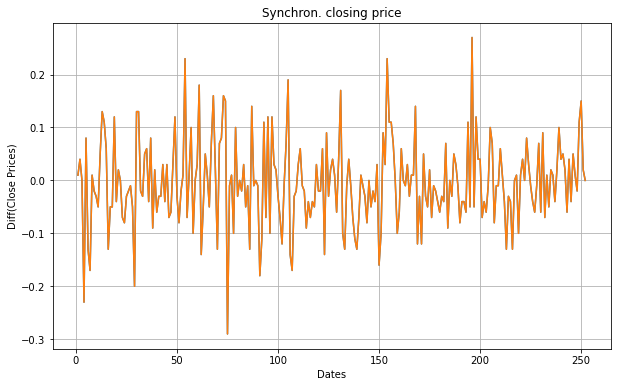

In [73]:
# checking to see if you can make the data stationary 
close = sync['Close']
close_log = np.log(close)
adfuller(close_log)
#variance doesn't seem to be the issue as the adfuller test shows that the data after being transformed is still non stationary , should try and de trend
diff = close.diff().dropna()
diff
adfuller(diff)
#adding differened mean into data set 
sync.insert(7, "differenced close",diff, True)
# after de-trending the data by taking the mean, the adf test gives me a p value 7.164189495280811e-29, making the data staitonary 
#visulazation 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Diff(Close Prices)')
plt.plot(sync["differenced close"])
plt.title('Synchron. closing price')
plt.show()
# stationary. 


In [74]:
adfuller(diff)

(-15.961814484910224,
 7.164189495280811e-29,
 0,
 251,
 {'1%': -3.4566744514553016,
  '5%': -2.8731248767783426,
  '10%': -2.5729436702592023},
 -519.6054263345816)

Text(0.5, 1.0, 'PACF:diff')

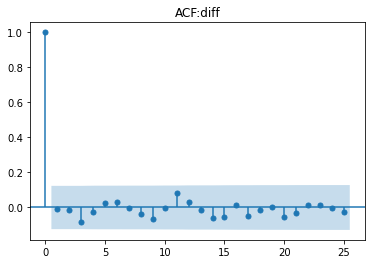

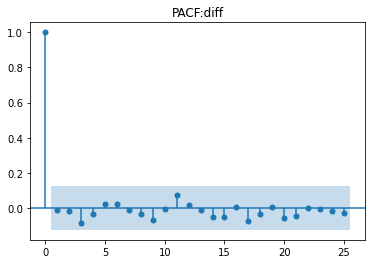

In [76]:
from statsmodels.tsa.stattools import pacf
plot_acf(diff)
plt.title("ACF:diff")
plot_pacf(diff)
plt.title("PACF:diff")

In [127]:
# from the acf and pacf graphs: for diff it seems like an ARMA (1,1) model but due to the differencing performed, it would be an ARIMA (1,1,1) model 
# before building a model, I should split the data into train and test data 
train_data, test_data = sync['Close'][3:int(len(sync['Close'])*0.9)],sync['Close'][int(len(sync['Close'])*0.9):]

#making an arima model 
model = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',      
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,  
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-471.585, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-469.653, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-469.657, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-471.659, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-467.655, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.054 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  224
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 236.830
Date:                Fri, 05 Aug 2022   AIC                           -471.659
Time:                        13:46:25   BIC                           -468.252
Sample:                             0   HQIC                          -470.284
                                - 224                                       

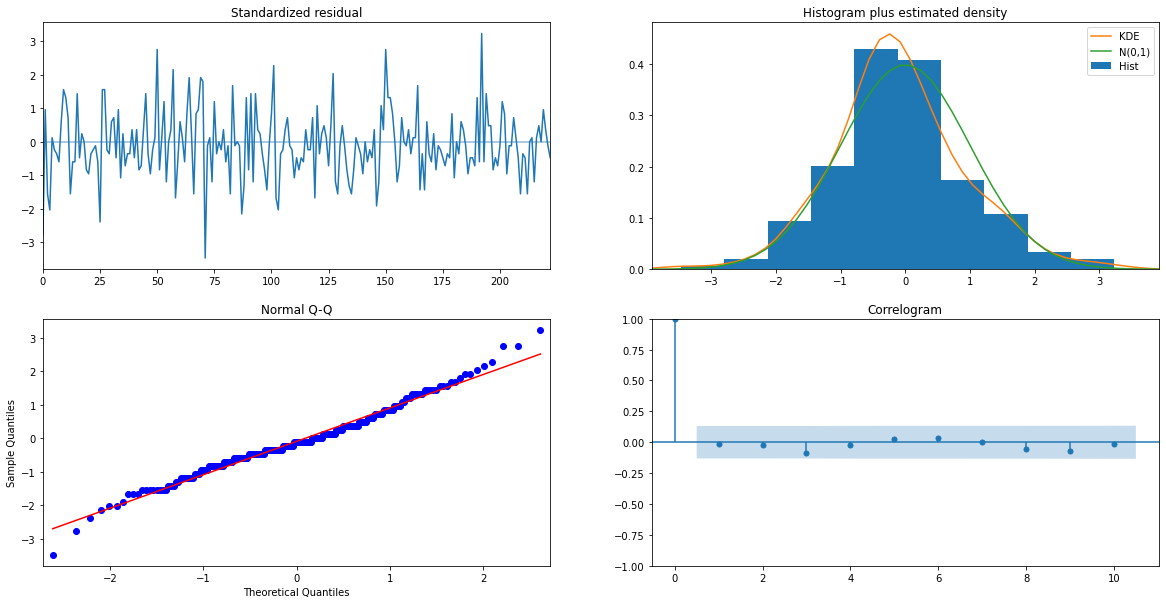

In [128]:
model.plot_diagnostics(figsize=(20,10))
plt.show()
# the plots below show the following: 
# the standardized residuals plot shows that the residual errors fluctuate around 0 and there are no patterns - doesnt violate the assumption of homoskedacticity 
# the histogram and normal qq plot shows that the assumption of normality is not violated 
# the correlogram shows that the assumption of no autocorrelation is not violated 
# we're good to use the model! no violated assumptions, its BLUE

In [129]:
# model using test data 
model_1 = ARIMA(train_data, order=(0, 1, 0))  
fitted = model_1.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 237.792
Method:                           css   S.D. of innovations              0.083
Date:                Fri, 05 Aug 2022   AIC                           -471.585
Time:                        13:46:38   BIC                           -464.771
Sample:                             1   HQIC                          -468.834
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0078      0.006     -1.391      0.164      -0.019       0.003


C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


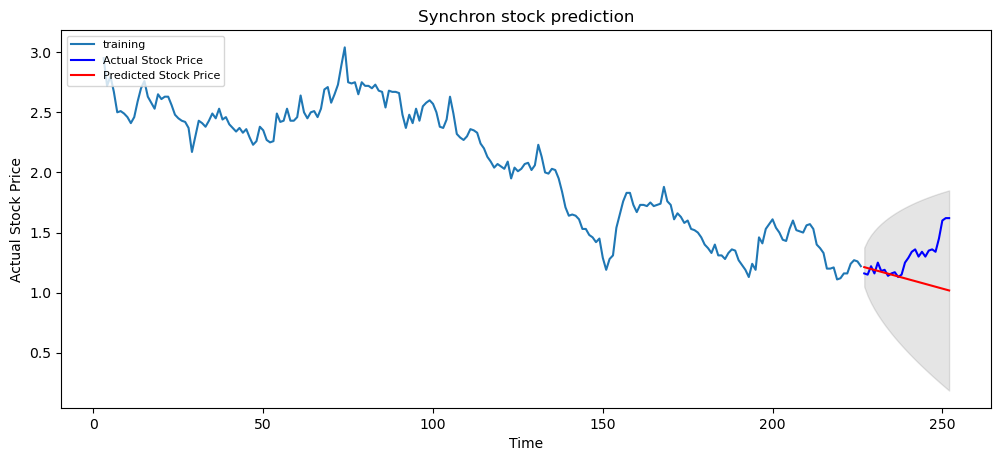

In [136]:
fc, se, conf = fitted.forecast(26, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'red',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Synchron stock prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [134]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

# model is 86.7% accurate in predictiing test set observations

MSE: 0.0697161314284348
MAE: 0.18844602548751382
RMSE: 0.2640381249525053
MAPE: 0.13305159474750153


In [ ]:
# This is a very basic project exploring the basics of time series analyis i learnt in an intro to time series regression course, This however 
# This model may provide a little bit of insight, however needs to be tweaked and understood much more to be used as a genuine time series model 
# this project was done PURELY to understand and play with time series data 
